# Liquid freshwater content anomaly in the SPNA and NSEA from EN4

In [1]:
import numpy as np
import xarray as xr

import shapely
import geopandas as gpd
import salem

import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


### Load salinity from EN4

In [2]:
en4 = xr.open_dataset('/mnt/efs/data/hadobs/salinity.nc')

In [4]:
# Add area
nc = xr.open_dataset('/mnt/efs/data/hadobs/hadobs_en4_area.nc')
en4['area'] = nc.area
en4.area.attrs= {'units': 'm^2','long_name': 'Grid area'}

### Set spatial and temporal range

In [5]:
south,north,west,east = 40,90,-110,45

tstart = '1900-01-15'
tend = '2017-12-15'

In [6]:
psal = en4.salinity.sel(time=slice(tstart,tend),lat=slice(south,north),lon=slice(west,east))

### Liquid freshwater content
The freshwater content (in meters) for each grid point is estimated as
$$ h_{fw} = \int_D^\eta f \, dz = \int_D^\eta \frac{S_{ref} - S}{S_{ref}} \, dz$$

In [7]:
psal_ref = 35.0
f = (psal_ref - psal)/psal_ref

depth_bnds = en4.depth_bnds
dz = (depth_bnds[:,1]-depth_bnds[:,0])
h_fw = (f * dz).sum('depth')

### Spatially integrate to obtain the liquid freshwater content (LFWC)
$$LFWC = \oint h_{fw}\; dA$$

For the subpolar gyre (SPG) we take the common spatial range of 50-62N and 10-60W

In [8]:
def get_gdf_patch(coords_patch):
    # Replace each pair of points by 10 points for projected map
    geometry = []
    segments = zip(coords_patch[:-2:2], coords_patch[1:-1:2], coords_patch[2::2], coords_patch[3::2])
    
    for line in [shapely.geometry.LineString([(x1, y1), (x2, y2)]) for (x1,y1,x2,y2) in segments]:
        for length in np.linspace(0,1,11):
            geometry.append( line.interpolate(length, normalized=True) )
        
    gdf_patch = gpd.GeoDataFrame([], geometry=geometry)
    
    # Convert Points to Polygo
    gdf_patch['geometry'] = gdf_patch['geometry'].apply(lambda x: x.coords[0])
    
    gdf_patch['shape_id'] = 0
    gdf_patch = gdf_patch.groupby('shape_id')['geometry'].apply(lambda x: shapely.geometry.Polygon(x.tolist())).reset_index()
    gdf_patch = gpd.GeoDataFrame(gdf_patch, geometry = 'geometry')
    
    # Salem uses this attribute:
    gdf_patch.crs = {'init': 'epsg:4326'}
    
    return gdf_patch

In [9]:
coords_spna = [-9.4, 50,-56.8, 50,-67.5, 62.3,-61.6, 66.7,-35, 66.7,-22.1, 66.1,-3.8, 59,-9.4, 50]
coords_nsea = [-3.8, 59,-22.1, 66.1,-35, 66.7,-29, 70,-25, 80,20, 80,20, 70,11, 64,5, 60,-3.8,59]

In [10]:
gdf_spna = get_gdf_patch(coords_spna)
gdf_nsea = get_gdf_patch(coords_nsea)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [11]:
h_fw_spna = h_fw.salem.roi(shape=gdf_spna.loc[[0]])
h_fw_nsea = h_fw.salem.roi(shape=gdf_nsea.loc[[0]])

/usr/local/lib/python3.6/dist-packages/salem/gis.py:66: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  out = pyproj.Proj(crs.to_proj4(), preserve_units=True)
/usr/local/lib/python3.6/dist-packages/salem/gis.py:66: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  out = pyproj.Proj(crs.to_proj4(), preserve_units=True)


In [12]:
Vfw_spna = (h_fw_spna * en4.area).sum(dim=['lat','lon'])
Vfw_nsea = (h_fw_nsea * en4.area).sum(dim=['lat','lon'])

# Convert from m^3 to km^3
Vfw_spna = Vfw_spna*1e-9
Vfw_nsea = Vfw_nsea*1e-9

In [13]:
# Anomaly
Vfw_spna_anom = Vfw_spna - Vfw_spna.mean('time')
Vfw_nsea_anom = Vfw_nsea - Vfw_nsea.mean('time')

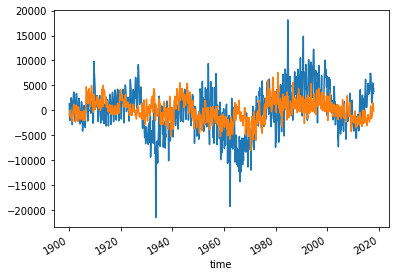

In [14]:
Vfw_spna_anom.plot()
Vfw_nsea_anom.plot()

In [15]:
ds_spna = Vfw_spna_anom.to_dataset(name='lfwc')
ds_nsea = Vfw_nsea_anom.to_dataset(name='lfwc')

In [16]:
ds_spna.to_netcdf('/mnt/efs/data/hadobs/en4_lfwc_spna_monthly.nc', format='NETCDF4',
                  encoding={'lfwc': {'zlib': True}})

In [17]:
ds_nsea.to_netcdf('/mnt/efs/data/hadobs/en4_lfwc_nsea_monthly.nc', format='NETCDF4',
                  encoding={'lfwc': {'zlib': True}})